In [3]:
import numpy as np
import matplotlib.pyplot as plt
import simpy
import random
import multiprocessing
import math

In [5]:
def locating_error(point1,point2, a):
    """
    Generates a new random point (x2', y2') within a circle.

    The circle's central point is (x2, y2).
    The radius of the circle is a * distance((x1, y1), (x2, y2)).

    Args:
        x1 (float): The x-coordinate of the first point.
        y1 (float): The y-coordinate of the first point.
        x2 (float): The x-coordinate of the circle's center.
        y2 (float): The y-coordinate of the circle's center.
        a (float): A scaling factor for the radius.

    Returns:
        tuple[float, float]: A new point (x2', y2') randomly generated within the circle.
    """

    x1 = point1[0]
    y1 = point1[1]
    x2 = point2[0]
    y2 = point2[1]

    # Step 1: Calculate the distance between the two original points.
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    # Step 2: Calculate the radius of the circle.
    radius = a * distance

    # Step 3: Generate a random distance from the center and a random angle.
    # To get a uniform distribution of points across the circle's area,
    # the random distance 'r' must be proportional to the square root of a uniform random number.
    r = radius * math.sqrt(random.uniform(0, 1))

    # Generate a random angle in radians between 0 and 2*pi.
    theta = random.uniform(0, 2 * math.pi)

    # Step 4: Calculate the offset from the center (x2, y2) using polar coordinates.
    offset_x = r * math.cos(theta)
    offset_y = r * math.sin(theta)

    # Step 5: Calculate the final coordinates of the new point.
    x_new = x2 + offset_x
    y_new = y2 + offset_y

    return np.array([x_new, y_new])

In [19]:
##############################################################################
# GSO PARAMETERS 
##############################################################################
dims = 1000
nturns = 800
bc = 5 # broadcast cycle
gamma = 0.9 # brightness weaken factor

In [7]:
# def fitness_function(xx, yy): # two targets
#     x = xx/200
#     y = yy/200
#     return 16 - ((x-3.14)**2 + (y-2.72)**2 + np.sin(3*x+1.41) + np.sin(4*y-1.73))

# def fitness_function(x, y): # Three-Hump Camel
#     x1 = x/180 - 2.9
#     x2 = y/180 - 2.9
#     # The formula for the Three-Hump Camel function
#     f_x = np.log(2 * x1**2 - 1.05 * x1**4 + (x1**6) / 6 + x1 * x2 + x2**2)
#     return (5-f_x)/10

In [10]:
##############################################################################
# Easom function based fied
##############################################################################
def Easom(x,y):
    return np.cos(x) * np.cos(y) * np.exp(-((x - np.pi)**2 + (y - np.pi)**2))

# def fitness_function(xx,yy): # one target
#     x = xx/200 - 0.5
#     y = yy/200 - 0.5
#     return Easom(x,y)

# def fitness_function(xx,yy): # two targets
#     x1 = xx/200 - 0.5
#     y1 = yy/200 - 0.5
#     z1 = Easom(x1,y1)
#     x2 = xx/180 + 2
#     y2 = yy/180 + 2
#     z2 = Easom(x2,y2)
#     return z1 + 0.7 * z2

def fitness_function(xx, yy): # 2 targets
    x1 = (xx-500)/100
    y1 = (yy-500)/100
    z1 = Easom(x1,y1)
    x4 = (xx+100)/100
    y4 = (yy+100)/100
    z4 = Easom(x4,y4)
    return z1 + z4

# def fitness_function(xx,yy): # three targets
#     x1 = xx/200 - 0.5
#     y1 = yy/200 - 0.5
#     z1 = Easom(x1,y1)
#     x2 = xx/180 + 2
#     y2 = yy/180 + 2
#     z2 = Easom(x2,y2)
#     x3 = xx/180 + 2
#     y3 = yy/180 - 1
#     z3 = Easom(x3,y3)
#     return z1 + 0.7 * z2 + 0.7 * z3

# def fitness_function(xx, yy): # four targets
#     x1 = (xx-500)/100
#     y1 = (yy-500)/100
#     z1 = Easom(x1,y1)
#     x2 = (xx+100)/100
#     y2 = (yy-500)/100
#     z2 = Easom(x2,y2)
#     x3 = (xx-500)/100
#     y3 = (yy+100)/100
#     z3 = Easom(x3,y3)
#     x4 = (xx+100)/100
#     y4 = (yy+100)/100
#     z4 = Easom(x4,y4)
#     # return z1 + 0.7 * z2 + 0.7 * z3 + 0.7 * z4
#     return z1 + z2 + z3 + z4


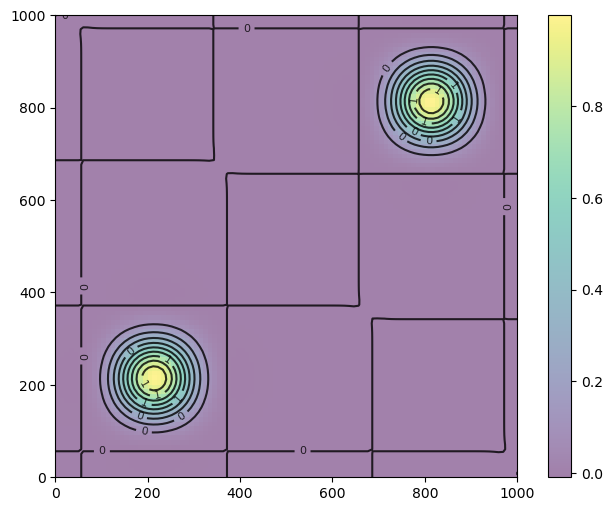

In [11]:
# Plotting - no Animation
x, y = np.array(np.meshgrid(np.linspace(0, dims, 100), np.linspace(0, dims, 100)))
z = fitness_function(x, y)

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, dims, 0, dims], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.8)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
plt.show()

In [12]:
##############################################################################
# Keep the swarm do not go beyond the boundary
##############################################################################
def keep_in_bounds(x, dims):
    if x < 0:
        return 0
    elif x > dims-10:
        return dims-10
    else:
        return x

In [13]:
"""
Compute the polar coordinates of (x1, y1) relative to (x2, y2).

Parameters
----------
(x1, y1) : numpy tuple of float
    Coordinates of the target point.
(x2, y2) : numpy tuple of float
    Coordinates of the reference point.

Returns
-------
(r, theta) : numpy tuple of floats
    r is the distance from (x1, y1) to (x2, y2).
    theta is the angle (in radians) from the positive x-axis.
"""

def to_relative_polar(x1, x2):
    dx = x1[0] - x2[0]
    dy = x1[1] - x2[1]
    
    r = np.sqrt(dx**2 + dy**2)      # Radial distance
    theta = np.arctan2(dy, dx)       # Angle in radians

    polar = np.array([r, theta])
    
    return polar

"""
Compute the cartesian coordinate of (x1, y1) when polar coordinate and cartesian coordinate of (x2, y2) are given.

Parameters
----------
(r, theta) : numpy tuple of floats
    r is the distance from (x1, y1) to (x2, y2).
    theta is the angle (in radians) from the positive x-axis.
(x2, y2) : numpy tuple of float
    Coordinates of the reference point.

Returns
-------
(x1, y1) : numpy tuple of float
    Coordinates of the target point.
"""

def to_cartesian(polar, x2):
    dx = x2[0] + np.cos(polar[1]) * polar[0]
    dy = x2[1] + np.sin(polar[1]) * polar[0]

    x1 = np.array([dx, dy])
    
    return x1

In [14]:
def weighted_random_choice(population, weights):
    """
    Selects a random element from a list with associated probabilities.

    Args:
        population: A sequence (list, tuple, etc.) of elements to choose from.
        weights: A sequence of weights, with each weight corresponding to
            the probability of selecting the element at the same index
            in the population. Weights must be non-negative and can be
            integers or floating-point numbers.

    Returns:
        A randomly selected element from the population, based on the weights.
    """
    #print(len(population), len(weights))
    if len(population) != len(weights):
        raise ValueError("Population and weights must have the same length")
    if any(w < 0 for w in weights):
      raise ValueError("Weights cannot be negative")

    return random.choices(population, weights=weights)[0]

In [15]:
##############################################################################
# FireFly Class & FUNCTIONS 
##############################################################################
class FireFly:
    def __init__(self, env, name, swarm, X=np.array([1, 1]), waypoint = np.array([1, 1]), broadcast_cycle=bc, 
                 speed=1.5433, transRange=150, locationErrorRate=0.0, score = 0.0):
        self.env = env
        self.name = name
        self.swarm = swarm  # List of all particles
        self.transmission_range = transRange
        self.speed = speed # 0.015433 -> 3 knots
        self.waypoint = waypoint
        self.locationErrorRate = locationErrorRate
        self.broadcast_cycle = broadcast_cycle
        

        self.X = X
        self.V = np.random.randn(2) * 0.1
        self.score = score # for transmisstion distance
        self.influenceTable = {name: {'distance':0.0, 'angle':0.0, 'score':0.0}} # name: distance, angle, score

        self.positions = [self.X.copy()]
        self.process = env.process(self.run())


    def sensing(self): # 
        """accquire the fitness of node's current position to calculate 'influence radius'."""
        self.score = fitness_function(self.X[0],self.X[1])
        # if found a better score
        if self.score > self.influenceTable[self.name]['score']:
            self.influenceTable[self.name]['score'] = self.score
            self.influenceTable[self.name]['angle'] = 0.0
            self.influenceTable[self.name]['distance'] = 0.0


    # def prepareMsgToSend(self):
    #     """Prepare to send a portion of the influence table to neighboring AUVs"""
    #     msgInfluenceTable = {}

    #     msgInfluenceTable = self.influenceTable # send all table

    #     # for key, value in self.influenceTable.items():
    #     #     if value['score'] >= self.score: # only send the entries with higher score than self
    #     #         msgInfluenceTable[key] = value

    #     # msgInfluenceTable = {self.name: {'distance':0.0, 'angle':0.0, 'score':self.score}}   # 

    #     #print(self.name)
    #     #print(msgInfluenceTable)
    #     return msgInfluenceTable


    def broadcast(self):
        """If node j is within node j's radius, record distance; else 0. For influence martrix"""
        for firefly in self.swarm:
            distance =  np.linalg.norm(self.X-firefly.X)
            if distance <= self.transmission_range: # Changed from self.score
                if firefly.name != self.name:
                    errorPoint = locating_error(self.X,firefly.X, self.locationErrorRate)
                    polar_cor = to_relative_polar(self.X, errorPoint)
                    # msgInfluenceTable = self.prepareMsgToSend()
                    msgInfluenceTable = self.influenceTable
                    firefly.receive(self.name, msgInfluenceTable, polar_cor) 


    def receive(self, node_name, node_msgInfluenceTable, polar_cor):
        """update the influenceTable"""
        for key, value in node_msgInfluenceTable.items():
            tableEntry_name = key
            tableEntry_distance = value['distance']
            tableEntry_score = value['score']
            tableEntry_angle = value['angle']
            tableEntry_polar = np.array([tableEntry_distance,tableEntry_angle])
            tableEntrytoSelf = to_relative_polar(to_cartesian(tableEntry_polar,np.array([0,0])) + to_cartesian(polar_cor,np.array([0,0])), np.array([0,0]))
            if (tableEntry_name not in self.influenceTable) or (self.influenceTable[tableEntry_name]['score'] < tableEntry_score):
                self.influenceTable[tableEntry_name] = {'distance':tableEntrytoSelf[0], 'angle':tableEntrytoSelf[1], 'score':tableEntry_score}
            

    def nextWaypoint(self): 
        """Calculate the node's next waypoint based on the Table of influences."""
        """Choose the best node"""
        new_position = np.array([0.0, 0.0])
        potentialnodeList = []
        scoreDiffList = []
        for firefly_name in self.influenceTable:
            firefly_score = self.influenceTable[firefly_name]['score']
            firefly_angle = self.influenceTable[firefly_name]['angle']
            firefly_distance = self.influenceTable[firefly_name]['distance']
            weaken_factor = int(firefly_distance/self.transmission_range)
            firefly_score = firefly_score*(gamma**weaken_factor) 
            if firefly_distance != 0 and self.score < firefly_score:
                scoreDiffList.append(firefly_score - self.score)
                potentialnodeList.append([firefly_distance,firefly_angle])

        if len(scoreDiffList) != 0:
            # # Make a weighted random choice of node
            # total = sum(scoreDiffList)
            # probabilities = [element / total for element in scoreDiffList]
            # chosennode = weighted_random_choice(potentialnodeList, probabilities)
            # new_position = to_cartesian(chosennode, self.X)

            # Make choice only the best one
            chosennode = potentialnodeList[scoreDiffList.index(max(scoreDiffList))]
            new_position = to_cartesian(chosennode, self.X)
            
            # Bound checking
            new_position[0] = keep_in_bounds(new_position[0], dims)
            new_position[1] = keep_in_bounds(new_position[1], dims)

            self.waypoint = new_position


    def move(self):  ### working on
        distance2Waypoint = np.linalg.norm(self.X - self.waypoint) # Euclidean distance
        if distance2Waypoint <= 3:  # Within in the threshold of waypoint
            self.nextWaypoint()     # Calculate next waypoint but do not move
        else: # make a move when still far from waypoint
            direction = self.waypoint-self.X
            newPosition = self.X + self.speed * (direction / np.linalg.norm(direction))
            for key, value in self.influenceTable.items(): # update influence table's polar cordinates
                prevPolar = np.array([value['distance'],value['angle']])
                nerghborX = to_cartesian(prevPolar,self.X)
                newPolar = to_relative_polar(nerghborX,newPosition)
                self.influenceTable[key]['distance'] = newPolar[0]
                self.influenceTable[key]['angle'] = newPolar[1]
            self.X = newPosition


    ##############################################################################
    # SIMPY INTEGRATION
    ##############################################################################
    def run(self):
        """
        A generator (process) that runs GSO for 'nturns' iterations in a SimPy environment.
        Each iteration is considered one time-step in the simulation.
        """
        i = 0
        while True:
            #print("Time ", i)
            # Compute firefly logic
            self.sensing()
            if i%self.broadcast_cycle == 0:
                self.broadcast()
            self.move()

            # Store positions for later analysis or plotting
            if i % 10 == 0:    
                self.positions.append(self.X.copy()) # take the records of position
                #print("name: ", self.name, " - score: ", self.score)
            i = i + 1

            # Advance simulated time by 1 time unit
            yield self.env.timeout(1)


In [16]:
# def starting_points_random(num_nodes):
#     """Initialize the node positions randomly."""
#     return np.random.rand(num_nodes, 2) * dims

def starting_points(num_nodes):
    """Evenly distribute particles on a grid within the search space."""
    list_firefly = []
    start = 0.05 * dims
    end = 0.95 * dims
    
    # Determine the number of rows and columns based on the number of particles
    n_side = int(np.ceil(np.sqrt(num_nodes)))  # Number of rows and columns in the grid
    x_coords = np.linspace(start, end, n_side)
    y_coords = np.linspace(start, end, n_side)

    # Create particles and assign grid positions
    for i in range(num_nodes):
        # Calculate grid coordinates (i.e., row and column)
        row = i // n_side
        col = i % n_side
        grid_position = np.array([x_coords[col], y_coords[row]])  # Assign grid position
        list_firefly.append(grid_position)
    
    return np.array(list_firefly)

# def starting_points_spiral(num_nodes: int):
#     """
#     Calculates and plots the positions of n nodes on an Archimedean spiral.

#     The spiral is centered in a square area and scaled to fit within its
#     boundaries.

#     Args:
#         num_nodes (int): The total number of nodes (AUVs) to plot.
#     """
#     # --- 1. Define Spiral Parameters ---
#     # The spiral is centered at (0,0), so the max radius is half the side length.
#     max_radius = dims * 0.45
    
#     # We define the spiral's "tightness" by the number of full rotations.
#     # More rotations create a denser spiral.
#     num_rotations = 10 
    
#     # Determine the spiral constant 'a' which controls the distance between arms.
#     # The formula is R = a * theta. We want R=max_radius at theta_max.
#     theta_max = num_rotations * 2 * np.pi
#     a = max_radius / theta_max
    
#     # --- 2. Calculate Node Positions ---
#     # Create an array of angles, one for each node, from 0 to theta_max.
#     theta = np.linspace(0, theta_max, num_nodes)
    
#     # Calculate the radius for each node based on its angle.
#     R = a * theta
    
#     # Convert from polar coordinates (R, theta) to Cartesian (x, y).
#     x_coords = R * np.cos(theta) + dims/2
#     y_coords = R * np.sin(theta) + dims/2

#     return np.stack((x_coords, y_coords), axis=1)

In [17]:
def check_termination_condition(sim_env):
    while True:
        # count_within_radius = sum(
        #     np.linalg.norm(p.X - target_position) <= radius for p in particles
        # )
        # if (count_within_radius >= threshold * len(particles)) or (sim_env.now >= nturns):
        #     #print(f"Condition met at time {env.now}: {count_within_radius}/{len(particles)} particles near target.")
        #     return [sim_env.event().succeed(),count_within_radius/len(particles)]  # Trigger the event to stop simulation

        if sim_env.now >= nturns:
            return [sim_env.event().succeed()]  # Trigger the event to stop simulation
        yield sim_env.timeout(1)

In [18]:
def run_firefly_simpy(AUVnum=36,transmissionRange=200):
    """
    Sets up the SimPy environment, runs the firefly process,
    and returns the recorded positions.
    """
    sim_env = simpy.Environment()

    # Initial population
    num_nodes = AUVnum
    T_R = transmissionRange
    pop = starting_points(num_nodes)

    # Create and start the GSO process
    swarm = []    
    for i in range(num_nodes):
        swarm.append(FireFly(env = sim_env, name = i, transRange = transmissionRange, swarm = [], 
                              X=pop[i], waypoint = pop[i]+np.random.uniform(-50, 50, size=2)))

    for firefly in swarm:
        firefly.swarm = swarm  # Give each firefly the list of all firefly
        #particle.target = [target_position,target_fitness]

    # Run the simulation
    termination_event = sim_env.process(check_termination_condition(sim_env))
    sim_env.run(until=termination_event)  # Simulation stops when termination_event is triggered

    swarm_positions = []
    for firefly in swarm:
        swarm_positions.append(firefly.positions)

    # count_within_radius = sum(np.linalg.norm(firefly.X - np.array([x_max, y_max])) <= 10 for firefly in swarm)

    return swarm_positions, sim_env.now

In [20]:
##############################################################################
# MAIN - multi Process
##############################################################################
if __name__ == "__main__":
    processes = []
    results = []
    TR = 150
    AUV_N = 100
    # numProcesses = 12
    swarm_positions, duration = run_firefly_simpy(AUVnum=AUV_N,transmissionRange=TR)

In [53]:
# def worker_function(AUVnum=25,transmissionRange=200):
#     # Perform CPU-bound computation on 'data'
#     AggregatePercentageList = []
#     AggregateDurationList = []
#     roundOfSimulation = 10
#     for i in range(roundOfSimulation):
#         all_positions,AUVpercentage,sim_duration = run_gso_simpy(AUVnum,transmissionRange)
#         AggregatePercentageList.append(AUVpercentage)
#         AggregateDurationList.append(sim_duration)
#         print(AUVpercentage, sim_duration)
#     avgAggregatePercentage = np.mean(AggregatePercentageList)
#     avgAggregateDuration = np.mean(AggregateDurationList)
#     print('AUV_NUM: ',AUVnum, ' AVG %: ', avgAggregatePercentage, ' AVG Duration: ',avgAggregateDuration)
#     return avgAggregatePercentage,avgAggregateDuration

In [ ]:
# if __name__ == "__main__":
#     processes = []
#     results = []
#     transmissionRange=200
#     numProcesses = 12
#     p = multiprocessing.Process(target=worker_function, args=(AUVnum,transmissionRange,))

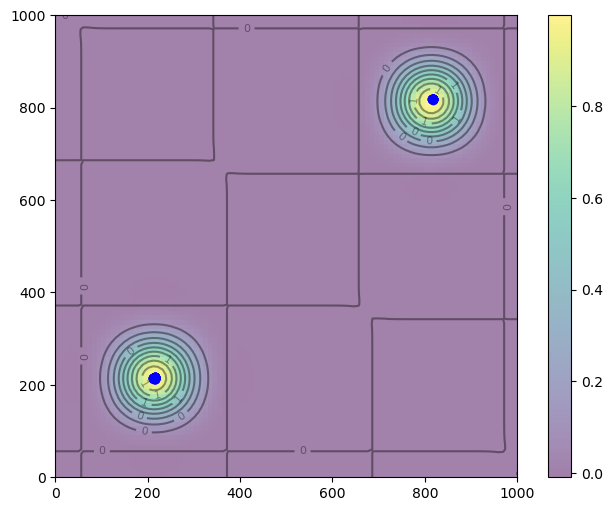

In [28]:
# Plotting - no Animation
num_nodes = AUV_N
x, y = np.array(np.meshgrid(np.linspace(0, dims, 100), np.linspace(0, dims, 100)))
z = fitness_function(x, y)

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, dims, 0, dims], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

i = 80
ax.clear()
ax.imshow(z, extent=[0, dims, 0, dims], origin='lower', cmap='viridis', alpha=0.5)
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
x_list = []
y_list = []
for j in range(num_nodes):
    x_list.append(swarm_positions[j][i][0])
    y_list.append(swarm_positions[j][i][1])
p_plot = ax.scatter(x_list, y_list, marker='o', color='blue', alpha=0.5)
plt.show()

In [29]:
t = 80
ll = []
r = 15
targets = np.array([[214.16,214.16],[814.16,814.16]])
counts = [0,0]
for j in range(num_nodes):
    for i in range(len(counts)):
        if np.linalg.norm(swarm_positions[j][80]-targets[i]) <= r:
            counts[i] = counts[i] + 1
print(targets)
print(counts)

[[214.16 214.16]
 [814.16 814.16]]
[69, 31]
